In [1]:
import bs4, tiktoken, numpy as np, os, datetime, uuid
from typing import Literal, Optional, Tuple
from youtube_transcript_api import YouTubeTranscriptApi
from pydantic import BaseModel, Field
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings

from langchain import hub
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.prompts import ChatPromptTemplate
from langchain.storage import InMemoryByteStore
from langchain.retrievers.multi_vector import MultiVectorRetriever

from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders import WebBaseLoader, YoutubeLoader

from langchain_core.documents import Document
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

from dotenv import load_dotenv
load_dotenv()

learn_api_key = os.environ['LANGSMITH_API_KEY']
openai_api_key = os.environ['OPENAI_API_KEY']
groq_api_key = os.environ['GROQ_API_KEY']
anthropic_api_key = os.environ['ANTHROPIC_API_KEY']

### Multi-representation Indexing

In [2]:
loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

loader = WebBaseLoader("https://lilianweng.github.io/posts/2024-02-05-human-data-quality/")
docs.extend(loader.load())

In [3]:
chain = (
    {"doc" : lambda x:x.page_content}
    | ChatPromptTemplate.from_template("Summarize the following document:\n\n{doc}")
    | ChatGroq(model="llama-3.3-70b-versatile", api_key=groq_api_key, temperature=0, max_retries=0)
    | StrOutputParser()
)

summaries = chain.batch(docs, {"max_concurrency":5})

In [4]:
# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="summaries", embedding_function=HuggingFaceEmbeddings())
# sentence-transformers/all-MiniLM-L6-v2

# The storage layer for the parent documents
store = InMemoryByteStore()
docstore = {}  # Use a dict for docstore
id_key = "doc_id"

# The retriever
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    docstore=docstore,
    id_key=id_key,
)

doc_ids = [str(uuid.uuid4()) for _ in docs]

# Docs linked to summaries
summary_docs = [
    Document(page_content=s, metadata={id_key:doc_ids[i]})
    for i, s in enumerate(summaries)
]

# Add
retriever.vectorstore.add_documents(summary_docs)
retriever.docstore.mset(list(zip(doc_ids, docs)))

C:\Users\user\AppData\Local\Temp\ipykernel_15232\4133976571.py:2: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(collection_name="summaries", embedding_function=HuggingFaceEmbeddings())


In [5]:
query = "Memory in agents"

sub_docs = vectorstore.similarity_search(query, k=1)
sub_docs[0]

Document(metadata={'doc_id': '9c48de2f-dd97-4670-9607-c3d49fd318d3'}, page_content="The document discusses the concept of LLM (Large Language Model) powered autonomous agents, which are systems that use LLMs as their core controller. The author, Lilian Weng, explores the key components of such agents, including planning, memory, and tool use.\n\n**Planning**: The author discusses various techniques for planning in LLM-powered agents, including task decomposition, self-reflection, and chain of thought (CoT) prompting. CoT involves breaking down complex tasks into smaller, manageable steps, while self-reflection allows the agent to learn from its mistakes and refine its plans.\n\n**Memory**: The author explains that memory can be categorized into short-term and long-term memory. Short-term memory refers to the limited context window of the LLM, while long-term memory involves storing information in an external vector store that can be retrieved using maximum inner product search (MIPS) a

In [6]:
retrieved_docs = retriever.get_relevant_documents(query, n_results=1)
retrieved_docs[0].page_content[:500]

C:\Users\user\AppData\Local\Temp\ipykernel_15232\17140411.py:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = retriever.get_relevant_documents(query, n_results=1)


"\n\n\n\n\n\nLLM Powered Autonomous Agents | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\n\n\n\n\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\n\n\nAgent System Overview\n\nComponent One: Planning\n\nTask Decomposition\n\nSelf-Reflection\n\n\nComponent Two: Memory\n\nTypes of Memory\n\nMaximum Inner Product Search (MIPS)\n\n\nComponent Three:"

### RAPTOR (Hierarchical Indexing)

In [7]:
import matplotlib.pyplot as plt, tiktoken
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

# LCEL docs
url = "https://python.langchain.com/docs/expression_language/"
loader = RecursiveUrlLoader(url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text)
docs = loader.load()

# LCEL with PydanticOutputParser (outside the primary LCEL docs)
url = "https://python.langchain.com/docs/modules/model_io/output_parsers/quick_start"
loader = RecursiveUrlLoader(url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text)
docs_pydantic = loader.load()

# LCEL with Self Query (outside the primary LCEL docs)
url = "https://python.langchain.com/docs/modules/data_connection/retrievers/self_query/"
loader = RecursiveUrlLoader(url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text)
docs_sq = loader.load()

# Doc texts
docs.extend([*docs_pydantic, *docs_sq])
docs_texts = [d.page_content for d in docs]

# Calculate the number of tokens for each document
counts = [num_tokens_from_string(d, "cl100k_base") for d in docs_texts]

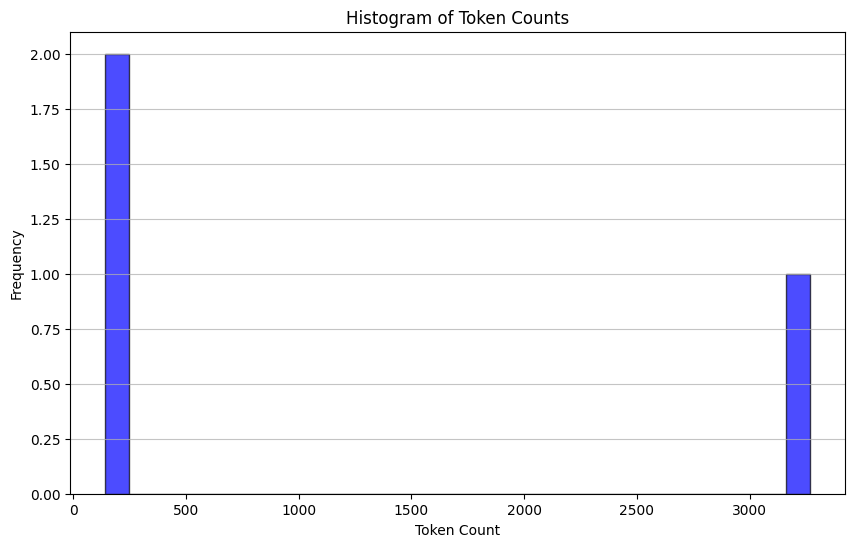

In [8]:
# Plotting histogram of token counts
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)

# Display the histogram
plt.show()

In [9]:
# Doc texts concat
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join([doc.page_content for doc in d_reversed])
print(f"Num tokens in all context: {num_tokens_from_string(concatenated_content, 'cl100k_base')}")

Num tokens in all context: 3555


In [10]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
# Doc texts split
chunk_size_tok = 2000
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=chunk_size_tok, chunk_overlap=0)
texts_split = text_splitter.split_text(concatenated_content)

In [11]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_groq import ChatGroq
embd = HuggingFaceEmbeddings()

model = ChatGroq(model="llama-3.3-70b-versatile", api_key=groq_api_key, temperature=0,)

In [12]:
from typing import Dict, List, Optional, Tuple
import numpy as np, pandas as pd, umap
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sklearn.mixture import GaussianMixture

RANDOM_SEED = 224

def global_cluster_embeddings(embeddings: np.ndarray, dim: int, n_neighbors: Optional[int] = None, metric: str = "cosine",)-> np.ndarray:
    """
    Perform global dimensionality reduction on the embeddings using UMAP.
    
    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - n_neioghbors: Optional; the number of neighbors to consider for each point.
                    If not provided, it defaults to the square root of the number of embeddings.
    - metric: The distance metric to use for UMAP.
    
    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(n_neighbors=n_neighbors, n_components=dim, metric=metric).fit_transform(embeddings)

In [13]:
def local_cluster_embeddings(embeddings: np.ndarray, dim: int, n_neighbors: int = 10, metric: str = "cosine",)-> np.ndarray:
    """
    Perform local dimensionality reduction on the embeddings using UMAP, typically after global clustering.
    
    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - n_neioghbors: The number of neighbors to consider for each point.
    - metric: The distance metric to use for UMAP.
    
    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    return umap.UMAP(n_neighbors=n_neighbors, n_components=dim, metric=metric).fit_transform(embeddings)

In [14]:
def get_optimal_clusters(embeddings: np.ndarray, max_clusters: int = 50, random_state: int = RANDOM_SEED) -> int:
    """
    Determine the optimal number of clusters using the Bayesian Information Criterion (BIC) with a Gaussian Mixture
    
    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - max_clusters: The maximum nbumber of clusters to consider.
    - random_state: Seed for reproducibility.
    
    Returns:
    - Am integer representing the optimal number of clusters found.
    """
    max_clusters = min(max_clusters, len(embeddings))
    n_clusters = np.arange(1, max_clusters)
    bics = []
    for n in n_clusters:
        gm = GaussianMixture(n_components=n, random_state=random_state)
        gm.fit(embeddings)
        bics.append(gm.bic(embeddings))
    return n_clusters[np.argmin(bics)]

In [15]:
def GMM_cluster(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    """
    Cluster embeddings using a Gaussian Mixture Model (GMM) based on a probability threshold.
    
    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - threshold: The probability threshold for assigning an embedding to a cluster.
    - random_state: Seed for reproducibility.
    
    Returns:
    - A tuple containing the cluster labels and the number of clusters determined.
    """
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state)
    gm.fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters

In [16]:
def perform_clustering(embeddings: np.ndarray, dim: int, threshold: float,) -> List[np.ndarray]:
    """
    Perform clustering on the embeddings by first reducing their dimensionality globally, then clustering 
    a Gaussian Mixture Model, and finally performing local clustering within each global cluster.
    
    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for UMAP reduction.
    - threshold: The probability threshold for assigning an embedding to a cluster in GMM.
    
    Returns:
    - A list of numpy arrays, where each array contains the cluster IDs for each embedding.
    """
    if len(embeddings) <= dim + 1:
        # Avoid clustering when there's insufficient data
        return [np.array([0]) for _ in range(len(embeddings))]
    
    # Global dimensionality reduction
    reduced_embeddings_global = global_cluster_embeddings(embeddings, dim)
    # Global clustering
    global_clusters, n_global_clusters = GMM_cluster(reduced_embeddings_global, threshold)

    all_local_clusters = [np.ndarray([]) for _ in range(len(embeddings))]
    total_clusters = 0

    # Iterate through each global cluster to perform local clustering
    for i in range(n_global_clusters):
        # Extract embeddings belonging to the current global cluster
        global_cluster_embeddings_ = embeddings[np.array([i in gc for gc in global_clusters])]

        if len(global_cluster_embeddings_) == 0:
            continue
        if len(global_cluster_embeddings_) <= dim + 1:
            # Handle small clusters with direct assignment
            local_clusters = [np.array([0]) for _ in global_cluster_embeddings_]
            n_local_clusters = 1
        else:
            # Local dimensionality reduction and clustering
            reduced_embeddings_local = local_cluster_embeddings(global_cluster_embeddings_, dim)
            local_clusters, n_local_clusters = GMM_cluster(reduced_embeddings_local, threshold)
        
        # Assign local cluster IDs, adjusting for total cluster already processed
        for j in range(n_local_clusters):
            local_cluster_embeddings_ = global_cluster_embeddings_[np.array([j in lc for lc in local_clusters])]
            indices = np.where((embeddings == local_cluster_embeddings_[:, None]).all(-1))[1]
            for idx in indices:
                all_local_clusters[idx] = np.append(all_local_clusters[idx], j + total_clusters)
        total_clusters += n_global_clusters
    return all_local_clusters

In [17]:
def embed(texts):
    """
    Generate embeddings for a list of text documents.
    
    This function assumes the existence of an 'embd' object with a method 'embed_documents'
    that takes a list of texts and returns their embeddings.
    
    Parameters:
    - texts: List[str], a list of text documents to be embedded.
    
    Returns:
    - numpy.ndarray: An array of embeddings for the given text documents.
    """
    text_embeddings = embd.embed_documents(texts)
    text_embeddings_np = np.array(text_embeddings)
    return text_embeddings_np

In [18]:
def embed_cluster_texts(texts):
    """
    Embeds a list of texts and clusters them, returning a DataFrame with texts, their embeddings, and cluster labels.
    
    This function combines embedding generation and clustering into a single step. It assumes the existence of a previously
    defined 'perform_clustering' function that performs clustering on the embeddings.
    
    Parameters:
    - texts: List[str], a list of text documents to be processed.
    
    Returns:
    - pandas.DataFrame: A DataFrame containing the original texts, their embeddings, and the assigned cluster labels
    """
    text_embeddings_np = embed(texts)  # Generate embeddings
    cluster_labels = perform_clustering(text_embeddings_np, 10, 0.1)  # Perform clustering on the embeddings
    df = pd.DataFrame()  # Initialize a DataFrame to store the results
    df["text"] = texts
    df["embd"] = list(text_embeddings_np)
    df["cluster"] = cluster_labels
    return df

In [19]:
def fmt_txt(df: pd.DataFrame) -> str:
    """
    Formats the text documents in a DataFrame into a single string.

    Parameters:
    - df: DataFrame containing the 'text' column with text documents to format.

    Returns:
    - A single string where all text documents are joined by a specific delimiter.
    """
    unique_txt = df["text"].tolist()
    return "--- --- \n --- --- ".join(unique_txt)

In [20]:
def embed_cluster_summarize_texts(texts: List[str], level: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Embeds, clusters, and summarizes a list of texts. This function first generates embeddings for the texts,
    clusters them based on similarity, expands the cluster assignments for easier processing, and then summarizes 
    the content within each cluster.

    Parameters:
    - texts: A list of text documents to be processed.
    - level: An integer parameter that could define the depth or detail of processing.

    Returns:
    - Tuple containing two DataFrames:
      1. The first DataFrame ('df_clusters') includes the original texts, their embeddings, and cluster assignment.
      2. The second DataFrame ('df_summary') contains summaries for each cluster, the specified level of detail,
         and the cluster identifiers.
    """

    # Embed and cluster the texts, resulting in a DataFrame with 'text', 'embd', and 'cluster' columns
    df_clusters = embed_cluster_texts(texts)

    # Prepare to expand the DataFrame for easier manipulation of clusters
    expanded_list = []

    # Expand DataFrame entries to document-cluster pairings for straightforward processing
    for index, row in df_clusters.iterrows():
        for cluster in row["cluster"]:
            expanded_list.append({"text": row["text"], "embd": row["embd"], "cluster": cluster})
    
    # Create a new DataFrame from the expanded list
    expanded_df = pd.DataFrame(expanded_list)

    # Retrieve unique cluster identifiers for processing
    all_clusters = expanded_df["cluster"].unique()
    print(f"--Generated {len(all_clusters)} clusters--")

    # Summarization
    template = """Here is a sub-set of LangChain Expression Language doc.
    
    LangChain Expression Language provides a way to compose chain in LangChain.
    
    Give a detailed summary of the documentation provided.
    
    Documentation:
    {context}
    """
    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | model | StrOutputParser()

    # Format text within eaech cluster for summarization
    summaries = []
    for i in all_clusters:
        df_cluster = expanded_df[expanded_df["cluster"] == i]
        formatted_txt = fmt_txt(df_cluster)
        summaries.append(chain.invoke({"context": formatted_txt}))

    # Create a DataFrame to store summaries with their corresponding cluster and level
    df_summary = pd.DataFrame({"summaries":summaries, "level": [level]* len(summaries), "cluster": list(all_clusters),})
    return df_clusters, df_summary

In [21]:
def recursive_embed_cluster_summarize(texts: List[str], level: int = 1, n_levels: int = 3) -> Dict[int, Tuple[pd.DataFrame, pd.DataFrame]]:
    """
    Recursively embeds, clusters, and summarizes texts up to a specified level or until the number of unique clusters becomes 1,
    storing the results at each level.

    Parameters:
    - texts: List[str], texts to be processed.
    - level: int, current recursion level (starts at 1).
    - n_levels: int, maximum depth of recursion.

    Returns:
    - Dict[int, Tuple[pd.DataFrame, pd.DataFrame]], a dictionary where keys are the recursion levels and values are tuples containing
      the clusters DataFrame and summaries DataFrame at that level.
    """
    results = {}  # Dictionary to store results at each level

    # Perform embedding, clustering, and summarization for the current level
    df_clusters, df_summary = embed_cluster_summarize_texts(texts, level)

    # Store the results of the current level
    results[level] = (df_clusters, df_summary)

    # Determine if further recursion is possible and meaningful
    unique_clusters = df_summary["cluster"].nunique()
    if level < n_levels and unique_clusters > 1:
        # Use summaries as the input text for the next level of recursion
        new_texts = df_summary["summaries"].tolist()
        next_level_results = recursive_embed_cluster_summarize(new_texts, level + 1, n_levels)

        # Merge the result from the next level into the current results dictionary
        results.update(next_level_results)
    return results

In [22]:
# Build tree
leaf_texts = docs_texts
results = recursive_embed_cluster_summarize(leaf_texts, level=1, n_levels=3)

--Generated 1 clusters--


In [23]:
from langchain_community.vectorstores import Chroma

# Initialize all_texts with leaf_texts
all_texts = leaf_texts.copy()

# Iterate through the results to extract summaries from each level and add them to all_texts
for level in sorted(results.keys()):
    # Extract summaries from the current level's DataFrame
    summaries = results[level][1]["summaries"].tolist()
    # Extent all_texts with the summaries from the current level
    all_texts.extend(summaries)

# Now, use all_texts to build the vectorstore with Chroma
vectorstore = Chroma.from_texts(texts=all_texts, embedding=embd)
retriever = vectorstore.as_retriever()

In [24]:
from langchain import hub
from langchain_core.runnables import RunnablePassthrough

# Propmt
prompt = hub.pull("rlm/rag-prompt")

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = ({"context": retriever | format_docs, "question": RunnablePassthrough()} | prompt | model | StrOutputParser())

# Question
rag_chain.invoke("How to define a RAG chain? Give me a specific code example.")

'To define a RAG (Retrieval Augmented Generation) chain, you can use the LangChain Expression Language (LCEL) to compose existing Runnables together. A specific code example is not provided in the given context, but you can use the `RunnableSequence` and `RunnableParallel` composition primitives to build a RAG chain. For example, you can use `RunnableSequence` to chain multiple runnables sequentially, with the output of one runnable serving as the input to the next.'

### ColBERT

In [25]:
from ragatouille import RAGPretrainedModel
RAG = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

C:\Users\user\AppData\Local\Temp\ipykernel_15232\276443619.py:1: UserWarning: 
********************************************************************************
RAGatouille WARNING: Future Release Notice
--------------------------------------------
RAGatouille version 0.0.10 will be migrating to a PyLate backend 
instead of the current Stanford ColBERT backend.
PyLate is a fully mature, feature-equivalent backend, that greatly facilitates compatibility.
However, please pin version <0.0.10 if you require the Stanford ColBERT backend.
********************************************************************************
  from ragatouille import RAGPretrainedModel


artifact.metadata: 0.00B [00:00, ?B/s]

c:\Users\user\Desktop\Projects\LangChain Tutorials\learn\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\user\.cache\huggingface\hub\models--colbert-ir--colbertv2.0. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/405 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

[Aug 17, 00:23:13] Loading segmented_maxsim_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


W0817 00:23:13.998000 15232 Lib\site-packages\torch\utils\cpp_extension.py:466] Error checking compiler version for cl: [WinError 2] The system cannot find the file specified


CalledProcessError: Command '['where', 'cl']' returned non-zero exit status 1.

In [ ]:
import requests

def get_wikipedia_page(title: str):
    """
    Retrieve the full context of a Wikipedia page.
    
    :param title: str - Title of the Wikipedia page.
    :return: str - Full text content of the page as raw string.
    """
    # Wikipedia API endpoint
    URL = "https://en/wikipedia.org/w/api.php"

    # Parameters for the API request
    params = {
        "action": "query",
        "format": "json",
        "titles": title,
        "prop": "extracts",
        "explaintext": True,
    }

    # Custom User-Agent header to comply with Wikipedia's best practices
    headers = {"User-Agent": "RAGatouille_tutorial/0.0.1 (ben@clavie.eu)"}

    response = requests.get(URL, params=params, headers=headers)
    data = response.json()

    # Extracting page content
    page = next(iter(data["query"]["pages"].values()))
    return page["extract"] if "extract" in page else None

full_document = get_wikipedia_page("Hayao_Miyazaki")

In [ ]:
RAG.index(collection=[full_document], index_name="Miyazaki-123",max_document_length=180, split_documents=True,)
results = RAG.search(query="What animation studio did Miyazaki found?", k=3)
results

In [ ]:
retriever = RAG.as_langchain_retriever(k=3)
retriever.invoke("What animation studio did Miyazaki found?")